# **import Libs**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## **Data Pre-processing**

In [62]:
# Read dataset
dataset = pd.read_csv('breastCancer.csv')

In [63]:
# Show top 5 rows
dataset.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [64]:
# Replace '?' sysmbol with nan
dataset = dataset.replace('?',np.nan)

# Fill missing values
dataset = dataset.fillna(dataset.median())

# Update bare_nucleoli as integer
dataset['bare_nucleoli'] = dataset['bare_nucleoli'].astype('int64')

# Drop id column
dataset.drop('id',axis=1,inplace=True)

In [65]:
# Divide into X and y
X = dataset.drop('class',axis=1)
y = dataset['class']

# Perform Scaling
sc_x = StandardScaler()
X = sc_x.fit_transform(X)

# Split into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1)


## **Apply PCA**

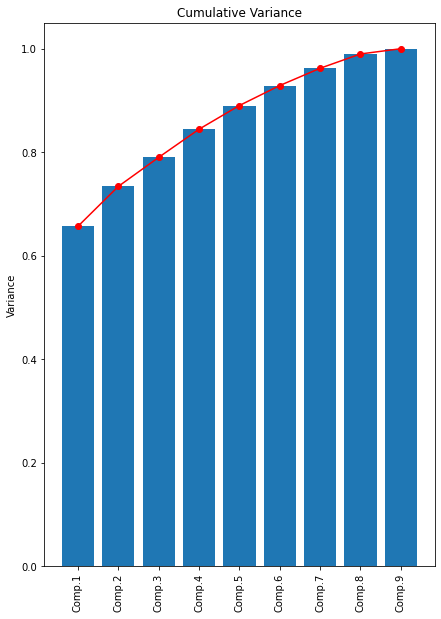

In [66]:
# Perform PCA
pca = PCA()
pca.fit(X_train)
pca_variance_ratio = pca.explained_variance_ratio_
pca_components = np.arange(len(pca_variance_ratio)) + 1

cumsum_pca_variance_ratio = np.cumsum((pca_variance_ratio))
plt.figure(figsize=(7, 10))
plt.bar(pca_components, cumsum_pca_variance_ratio)
plt.plot(pca_components, cumsum_pca_variance_ratio, "ro-")
plt.xticks(pca_components, ["Comp." + str(i) for i in pca_components], rotation=90)
plt.title("Cumulative Variance")
plt.ylabel("Variance")
plt.show()

In [67]:
# Select importatnt features
pca = PCA(n_components=5)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## **Fuction for Hyperparameter tuning**

In [68]:
def hyper_parameter_tuning(estimator_name, estimator, parameters):
    grid = GridSearchCV(estimator, parameters)
    grid.fit(X_train, y_train)
    print('***************************** Best Parameters ****************************')
    print(grid.best_params_)
    print('***************************** Best Estimator *****************************')
    print(grid.best_estimator_)
    params = pd.DataFrame(grid.cv_results_['params'])
    score = pd.DataFrame(grid.cv_results_['mean_test_score'], columns=['score'])
    print('************************** Score and parameters ***************************')
    params_and_scores = pd.concat([params, score], axis=1)
    params_and_scores.to_csv(f'{estimator_name}.csv', index=False)
    print(params_and_scores)

    return grid

## **Fuction for model creation**

In [69]:
def model_creation(model, X_train, X_test, y_train, y_test, cv=10):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    report = classification_report(y_test, predicted)
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>> Classificatio Report >>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print(report)
    print('========================== Cross validation score ===========================')
    print(np.mean(cross_val_score(model, X_train, y_train, cv=cv)))

## **Support vector machine**

In [55]:
svc_parameters = {'kernel': ['linear', 'poly', 'sigmoid', 'rbf']}
svc = SVC()
svc_hyper_parameter_tuning = hyper_parameter_tuning('Support vector machine', svc, svc_parameters)
svc = svc_hyper_parameter_tuning.best_estimator_
model_creation(svc, X_train, X_test, y_train, y_test)

***************************** Best Parameters ****************************
{'kernel': 'rbf'}
***************************** Best Estimator *****************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
************************** Score and parameters ***************************
    kernel     score
0   linear  0.956996
1     poly  0.938523
2  sigmoid  0.957038
3      rbf  0.961119
>>>>>>>>>>>>>>>>>>>>>>>>>>> Classificatio Report >>>>>>>>>>>>>>>>>>>>>>>>>>>
              precision    recall  f1-score   support

           2       0.99      0.99      0.99       137
           4       0.97      0.97      0.97        73

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       21

##**k-nearest neighbors**

In [56]:
knn_parameters = {'n_neighbors': [5, 10, 20, 40, 80],
                  'metric':['minkowski', 'euclidean', 'manhattan']}
knn = KNeighborsClassifier()
knn_hyper_parameter_tuning = hyper_parameter_tuning('k-nearest neighbors',knn, knn_parameters)
knn = knn_hyper_parameter_tuning.best_estimator_
model_creation(knn, X_train, X_test, y_train, y_test)

***************************** Best Parameters ****************************
{'metric': 'manhattan', 'n_neighbors': 20}
***************************** Best Estimator *****************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
************************** Score and parameters ***************************
       metric  n_neighbors     score
0   minkowski            5  0.952872
1   minkowski           10  0.959036
2   minkowski           20  0.963160
3   minkowski           40  0.963160
4   minkowski           80  0.954955
5   euclidean            5  0.952872
6   euclidean           10  0.959036
7   euclidean           20  0.963160
8   euclidean           40  0.963160
9   euclidean           80  0.954955
10  manhattan            5  0.954913
11  manhattan           10  0.959015
12  manhattan           20  0.965180
13  manhattan           4

##**Logistic Regression**

In [57]:
logistic_parameters = {'penalty':['l2', 'none']}
logistic = LogisticRegression()
logistic_hyper_parameter_tuning = hyper_parameter_tuning('Logistic Regression',logistic, logistic_parameters)
logistic = logistic_hyper_parameter_tuning.best_estimator_
model_creation(logistic, X_train, X_test, y_train, y_test)

***************************** Best Parameters ****************************
{'penalty': 'l2'}
***************************** Best Estimator *****************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
************************** Score and parameters ***************************
  penalty     score
0      l2  0.959036
1    none  0.956975
>>>>>>>>>>>>>>>>>>>>>>>>>>> Classificatio Report >>>>>>>>>>>>>>>>>>>>>>>>>>>
              precision    recall  f1-score   support

           2       0.98      0.99      0.99       137
           4       0.99      0.96      0.97        73

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.

##**Decision Tree**

In [58]:
decision_tree_parameters = {'criterion':['gini', 'entropy'],
                            'max_depth':[None, 5, 10, 20, 40],
                            'min_samples_split':[i for i in range(2, 5)],
                            'min_samples_leaf':[i for i in range(1, 5)],
                            'max_features':['auto', 'sqrt', 'log2']
                            }
decision_tree = DecisionTreeClassifier()
decision_tree_hyper_parameter_tuning = hyper_parameter_tuning('Decision Tree',decision_tree, decision_tree_parameters)
decision_tree = decision_tree_hyper_parameter_tuning.best_estimator_
model_creation(decision_tree, X_train, X_test, y_train, y_test)

***************************** Best Parameters ****************************
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4}
***************************** Best Estimator *****************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
************************** Score and parameters ***************************
    criterion  max_depth  ... min_samples_split     score
0        gini        NaN  ...                 2  0.952977
1        gini        NaN  ...                 3  0.930465
2        gini        NaN  ...                 4  0.938607
3

##**Random Forest**

In [59]:
random_forest_parameters = {'criterion':['gini', 'entropy'],
                            'n_estimators':[10, 50, 100, 200, 400, 600],
                            'max_depth':[None, 5, 10, 20, 40],
                            'min_samples_split':[i for i in range(2, 5)],
                            'min_samples_leaf':[i for i in range(1, 5)],
                            'max_features':['auto', 'sqrt', 'log2'],
                            'bootstrap': [True, False]
                            }
random_forest = RandomForestClassifier()
random_forest_hyper_parameter_tuning = hyper_parameter_tuning('Random Fores',random_forest, random_forest_parameters)
random_forest = random_forest_hyper_parameter_tuning.best_estimator_
model_creation(random_forest, X_train, X_test, y_train, y_test)

***************************** Best Parameters ****************************
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
***************************** Best Estimator *****************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
************************** Score and parameters ***************************
      bootstrap criterion  max_depth  ... min_samples_split  n_estimators     sco

##**Extra Trees**

In [70]:
extra_tree_parameters = {'criterion':['gini', 'entropy'],
                            'n_estimators':[10, 50, 100, 200, 400, 600],
                            'max_depth':[None, 5, 10, 20, 40],
                            'min_samples_split':[i for i in range(2, 5)],
                            'min_samples_leaf':[i for i in range(1, 5)],
                            'max_features':['auto', 'sqrt', 'log2'],
                            'bootstrap': [True, False]
                            }
extra_tree = ExtraTreesClassifier()
extra_tree_hyper_parameter_tuning = hyper_parameter_tuning('Extra Trees',extra_tree, extra_tree_parameters)
extra_tree = extra_tree_hyper_parameter_tuning.best_estimator_
model_creation(extra_tree, X_train, X_test, y_train, y_test)

***************************** Best Parameters ****************************
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
***************************** Best Estimator *****************************
ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=40, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
************************** Score and parameters ***************************
      bootstrap criterion  max_depth  ... min_samples_split  n_estimators     score
0      